## Data Preprocessing

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import uuid
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from gensim import corpora, models
from nltk import pos_tag
from gensim.models import CoherenceModel


from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import re
import spacy
import en_core_web_sm
from pandas.core.common import flatten
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from gensim.models import Word2Vec
  
lemmatizer = WordNetLemmatizer() 

In [4]:
#Read in the Pandas dataframe

import pandas as pd
from google.colab import files
import io

uploaded = files.upload() 

Saving PIT-UN Course Listing - Sheet1.csv to PIT-UN Course Listing - Sheet1.csv


In [5]:
df = pd.read_csv(io.BytesIO(uploaded['PIT-UN Course Listing - Sheet1.csv']))
df.head()

,University,Course Title,Link,Description,General Course Catalogue
0,Arizona State University,Principles of Public Interest Technology,NaN,NaN,NaN
1,Boston University,XCC433: Justice Media co-Lab,https://www.bu.edu/cds-faculty/programs/justic...,The Justice Media co-Lab provides the programm...,https://www.bu.edu/phpbin/course-search/
2,Boston University,Law & Algorithms,https://www.bu.edu/law/courses/lawjd673/,This cross-cutting and interdisciplinary cours...,NaN
3,Boston University,Data Science for Politics,https://www.bu.edu/academics/cas/courses/cas-p...,Data science is changing how we understand and...,NaN
4,Cal Poly State,Technically Human: The Art and the Ethics of T...,https://debdonig.wordpress.com/technically-hum...,"In this course, we will look critically at the...",NaN


In [6]:
#Importing and adding stop words with nltk 

nltk.download('stopwords')
stop = stopwords.words('english')
stop_add = ['said', 'year', 'like', 'says', 'years', 'month', 'months', 'day', 'days', 'say', 'would', 'in', 'of', '.', ',',':',';','`',"''",'s','-']
for new in stop_add:
    stop.append(new)
print(stop)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

In [7]:
#Function to remove stopwords

def remove_stopwords1(text):
    stop_words = stopwords.words('english')
    stop_words.extend(["also", "and", "its", "bring", "got", "from", "lot", "rather", "even", "from", "but","that","in","you","who","to", "of", "become", "thats", "looking"])
    words = [w for w in text if w not in stop_words]
    return words



In [10]:
#Calling the column name from the dataframe
ds = df[['Description']]

In [11]:
ds

,Description
0,NaN
1,The Justice Media co-Lab provides the programm...
2,This cross-cutting and interdisciplinary cours...
3,Data science is changing how we understand and...
4,"In this course, we will look critically at the..."
...,...
110,Undergraduate course The Value Sensitive Desig...
111,Data Science for Everyone is the flagship unde...
112,NaN
113,What does public interest technology look like...


## Word2Vec

In [12]:
nltk.download('punkt')
stop_clean = remove_stopwords1(ds['Description'])

#Converting all datatypes to strings
str_list = list(map(str, stop_clean))

lemmatized = []
for s in str_list:
    lemmatized.append(lemmatizer.lemmatize(s))

tokens = []
for i in lemmatized:
    i.lower()
    tokens.append(word_tokenize(i))
    

#Word2Vec model to make the word embeddings
model = Word2Vec(tokens, min_count=1, size=50, workers=3, window=2, sg=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [13]:
print(model)

Word2Vec(vocab=2414, size=50, alpha=0.025)


In [14]:
print(model.similarity('machine','learning'))

0.99516606


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


## Elbow Method (optimal number of clusters)

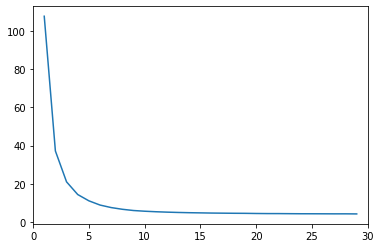

In [18]:
#Sum of Squared Errors - how to find optimal number of clusters for k-means (elbow method)

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 

sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)
    km = km.fit(X)
    sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, sum_of_squared_distances)
plt.xlim((0, 30))
plt.show()

## K Means Clustering with NLTK Library

In [ ]:
X = model[model.wv.vocab]

In [ ]:
print(X)

In [ ]:
print(model)

In [ ]:
from nltk.cluster import KMeansClusterer
import nltk
NUM_CLUSTERS=5
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
print (assigned_clusters)

[4, 0, 4, 1, 4, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 3, 0, 2, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 2, 0, 4, 3, 0, 4, 0, 0, 0, 3, 0, 0, 0, 0, 2, 1, 2, 0, 4, 3, 4, 0, 0, 0, 0, 4, 0, 0, 0, 3, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 3, 3, 1, 0, 4, 1, 0, 0, 0, 3, 3, 1, 1, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 1, 0, 2, 0, 3, 0, 0, 0, 0, 2, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 4, 1, 0, 0, 2, 0, 2, 2, 3, 1, 2, 0, 0, 0, 1, 0, 2, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 1, 4, 0, 4, 0, 3, 0, 3, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 

In [ ]:
words = list(model.wv.vocab)
for i, word in enumerate(words):  
    print (word + ":" + str(assigned_clusters[i]))

nan:4
The:0
Justice:4
Media:1
co-Lab:4
provides:0
the:0
programmatic:3
structure:0
to:0
train:0
a:0
new:0
generation:1
of:0
computational:0
investigative:0
journalists:1
equipped:3
leverage:3
power:0
computing:0
and:0
data:0
science:0
advance:0
justice:0
transparency:0
.:0
first:0
interdisciplinary:0
curricular:3
collaboration:0
between:0
CDS:0
other:0
disciplines:0
,:0
this:0
co-lab:1
aims:0
develop:0
test:3
an:0
institutional:0
framework:0
for:0
collaborations:0
(:0
faculty:0
students:0
external:0
partners:0
):0
around:0
courses:0
summer:0
programs:4
that:0
lead:0
student:0
placements:2
in:0
PIT:0
careers:0
This:0
cross-cutting:2
course:0
taught:0
alongside:3
graduate-level:0
with:0
BU:3
's:0
Computing:2
Data:0
Sciences:2
investigates:3
role:0
algorithms:0
automated:0
decision-making:0
systems:0
play:0
law:0
society:0
connects:3
legal:0
technical:0
concepts:0
fairness:0
bias:0
privacy:0
trust:3
though:2
series:0
case:0
studies:0
present:0
recent:0
applications:1
technology:0
regulato

In [ ]:
"""model.wv.most_similar(df)"""

'model.wv.most_similar(df)'

## K Means Clustering with Scikit-learn Library

In [19]:
from sklearn import cluster
from sklearn import metrics
kmeans = cluster.KMeans(n_clusters=5)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

Cluster id labels for inputted data
[0 4 0 ... 0 0 0]
Centroids data
[[-8.88301618e-03  7.38797523e-03 -2.52299383e-02 -1.95617191e-02
  -1.31319482e-02 -2.50447565e-03  2.04678848e-02 -7.95679633e-04
  -1.87011389e-03 -4.31745965e-03 -1.17733860e-02 -6.75556343e-03
   3.01395194e-04 -7.33430684e-03  1.49633996e-02  1.37761645e-02
  -7.78929517e-03 -5.94463944e-03  5.90184145e-03  9.91233625e-03
  -3.68987396e-03 -1.54322293e-02  6.22015446e-03 -1.21694012e-02
  -8.56736302e-03  9.83154401e-03  6.80425763e-03  1.89611712e-03
  -5.24404272e-03  9.48413834e-03 -8.64113867e-03 -1.43307541e-02
   8.71805754e-03 -1.23181043e-03 -1.24971122e-02 -9.44820605e-03
  -7.57866306e-04 -3.67103424e-03  1.50477663e-02  8.77056457e-03
  -1.44172497e-02 -4.15717484e-03 -1.40667707e-02 -8.35279003e-03
   1.26224067e-02  1.12479413e-02 -1.88990161e-02  3.13518802e-03
   1.87436957e-03 -2.33594794e-02]
 [-1.43835038e-01  1.19137220e-01 -4.08835948e-01 -3.18779200e-01
  -2.13529229e-01 -3.76392417e-02  3.3

In [20]:
from nltk.cluster import KMeansClusterer
import nltk
NUM_CLUSTERS=5
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
print (assigned_clusters)

[3, 0, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 2, 1, 0, 3, 0, 0, 1, 0, 0, 0, 3, 0, 3, 0, 3, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 2, 3, 2, 3, 0, 0, 3, 2, 0, 4, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 3, 0, 2, 4, 0, 0, 0, 0, 0, 2, 0, 0, 3, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 3, 3, 1, 0, 0, 0, 4, 3, 2, 3, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 2, 1, 2, 1, 0, 0, 1, 0, 4, 0, 2, 0, 0, 3, 3, 0, 0, 0, 0, 0, 4, 0, 3, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 

In [21]:
words = list(model.wv.vocab)
for i, word in enumerate(words):  
    print (word + ":" + str(assigned_clusters[i]))

nan:3
The:0
Justice:1
Media:1
co-Lab:1
provides:0
the:0
programmatic:2
structure:0
to:0
train:0
a:0
new:0
generation:0
of:0
computational:0
investigative:1
journalists:0
equipped:2
leverage:0
power:0
computing:0
and:0
data:0
science:0
advance:0
justice:0
transparency:0
.:0
first:0
interdisciplinary:0
curricular:4
collaboration:0
between:0
CDS:4
other:0
disciplines:0
,:0
this:0
co-lab:2
aims:0
develop:0
test:3
an:0
institutional:0
framework:0
for:0
collaborations:2
(:0
faculty:0
students:0
external:0
partners:0
):0
around:0
courses:0
summer:2
programs:0
that:0
lead:3
student:2
placements:1
in:0
PIT:3
careers:0
This:0
cross-cutting:1
course:0
taught:0
alongside:0
graduate-level:3
with:0
BU:3
's:0
Computing:3
Data:0
Sciences:3
investigates:3
role:0
algorithms:0
automated:0
decision-making:0
systems:0
play:0
law:0
society:0
connects:2
legal:0
technical:0
concepts:0
fairness:0
bias:0
privacy:0
trust:4
though:1
series:0
case:0
studies:0
present:0
recent:0
applications:0
technology:0
regulato

## Visualization Plot

In [ ]:
#Preprocessing for viz
import pandas as pd
data = []
labels = []
length = []
for i, word in enumerate(words):  
    data.append(word)
    labels.append(str(assigned_clusters[i]))
    length.append(len(word))
df = pd.DataFrame({"word": data, "label": labels, "length": length})
df

,word,label,length
0,nan,2,3
1,The,0,3
2,Justice,4,7
3,Media,3,5
4,co-Lab,3,6
...,...,...,...
2409,weekly,2,6
2410,Prerequisites,2,13
2411,Appropriate,2,11
2412,preparation,2,11


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 2 missing from current font.
  font.set_text(s, 0, flags=flags)


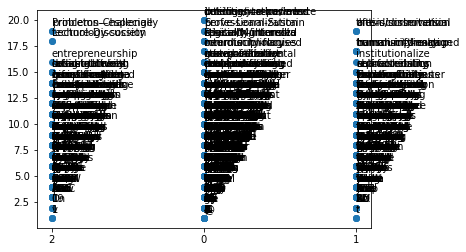

In [ ]:
import matplotlib.pyplot as plt
 
#Filter rows of original data
x = labels
y = length
text = data
 

for i in range(len(x)):
  plt.annotate(text[i], (x[i], y[i]+0.5))

#Plotting the results
plt.scatter(x , y)
plt.show()

In [ ]:
label0 = df.loc[df['label'] == 0]



## Visualization with centroids

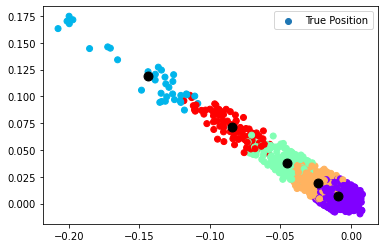

'These are the centroids'

In [22]:
import numpy as np
import matplotlib.pyplot as plt

#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(labels)

#Plotting the results:
plt.scatter(X[:,0],X[:,1], label='True Position', c=labels, cmap='rainbow')
#plt.scatter(df[labels == i , 0] , df[labels == i , 1] , labels = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')

plt.legend()
plt.show()
"""These are the centroids"""

#https://stackabuse.com/k-means-clustering-with-scikit-learn/